I have used the following methods.

* I used a pretrained <b>ViT</b> architecture for the feature extraction stage [1],
* <b>gelu</b> activation function during the classification stage,
* I used two image processing methods for images <b>(green channel conversion[2], contrast limited adaptive histogram equalization (CLAHE)[3]),</b>
* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,

<br>

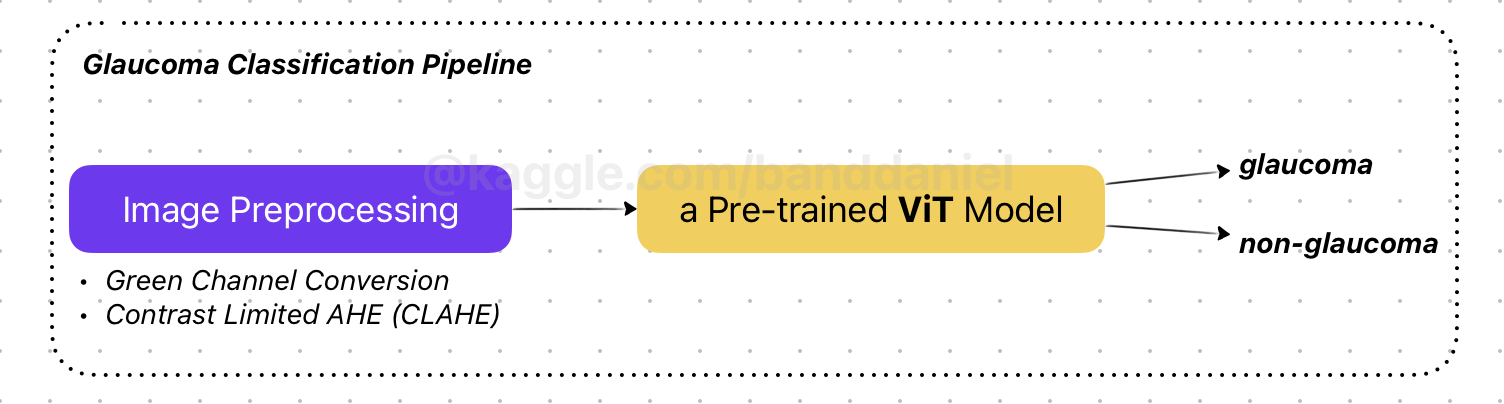


## Image Processing Operation

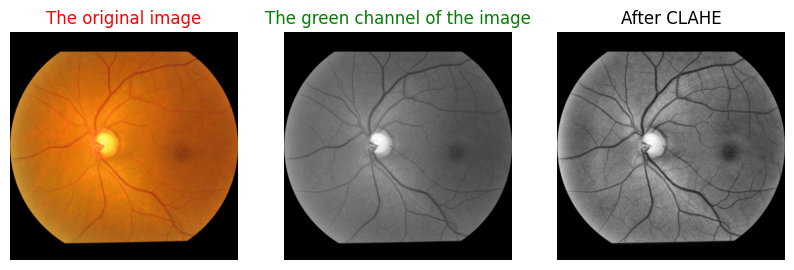

## My Another Project About Eyes

* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice : 0.91, Jaccard : 0.82)](https://github.com/john-fante/my-deep-learning-projects/tree/main/segmentation-projects/eye-conjunctiva-segmentation-main)
* [Retina Vessel Segmentation w/TPU (Test Dice: 0.75)](https://www.kaggle.com/code/banddaniel/retina-vessel-segmentation-w-tpu-test-dice-0-75)



## References
1. https://github.com/faustomorales/vit-keras
2. Rathod, Deepali & Manza, Ramesh & Rajput, Yogesh & Patwari, Manjiri & Saswade, Manoj & Deshpande, Neha. (2014). Localization of Optic Disc and Macula using Multilevel 2-D Wavelet Decomposition Based on Haar Wavelet Transform. International Journal of Engineering Research & Technology (IJERT)
3. https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import warnings
import logging
import os 
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from vit_keras import vit


IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 999
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [3]:
# Connecting TPU and creating strategy and the model

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

stg = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

# <span style="color:#e74c3c;"> Image </span> Processing

(-0.5, 511.5, 511.5, -0.5)

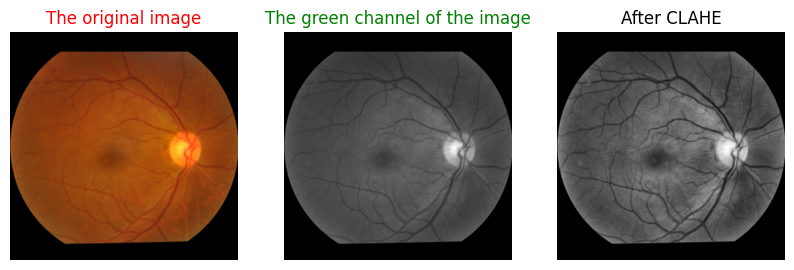

In [4]:
# An example of image operations

normal_image = cv2.imread('/kaggle/input/fundus-pytorch/train/0/BEH-250.png') #a normal rgb image
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB) #convert to rgb for plotting

green_channnel = normal_image[:,::,1] #splitting Green channel from a RGB image 

clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
final_img = clahe_op.apply(green_channnel)
    

fig, axs = plt.subplots(1,3, figsize = (10,5), dpi = 100)

axs[0].imshow(normal_image)
axs[0].set_title('The original image', color = 'red')
axs[0].axis('off')

axs[1].imshow(green_channnel, cmap = 'gray')
axs[1].set_title('The green channel of the image', color ='green')
axs[1].axis('off')

axs[2].imshow(final_img, cmap = 'gray')
axs[2].set_title('After CLAHE')
axs[2].axis('off')


In [5]:
# Creating new folders

os.mkdir(os.path.join('/kaggle/working/', 'train_converted_images'))
os.mkdir(os.path.join('/kaggle/working/train_converted_images/', '0'))
os.mkdir(os.path.join('/kaggle/working/train_converted_images/', '1'))

os.mkdir(os.path.join('/kaggle/working/', 'val_converted_images'))
os.mkdir(os.path.join('/kaggle/working/val_converted_images/', '0'))
os.mkdir(os.path.join('/kaggle/working/val_converted_images/', '1'))

os.mkdir(os.path.join('/kaggle/working/', 'test_converted_images'))
os.mkdir(os.path.join('/kaggle/working/test_converted_images/', '0'))
os.mkdir(os.path.join('/kaggle/working/test_converted_images/', '1'))

In [6]:
# A normal image > Green channel > Histogram Equalization

def image_cvt_histeq(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        #BGR images, I want to split the green channel
        img = cv2.imread(os.path.join(main_path, i))[:,::,1]         
        clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
        final_img = clahe_op.apply(img)
        
        cv2.imwrite(os.path.join(target_path, i), final_img)

In [7]:
# Applying the image processing function to all images

image_cvt_histeq('/kaggle/input/fundus-pytorch/train/0', '/kaggle/working/train_converted_images/0')
image_cvt_histeq('/kaggle/input/fundus-pytorch/train/1', '/kaggle/working/train_converted_images/1')

image_cvt_histeq('/kaggle/input/fundus-pytorch/val/0', '/kaggle/working/val_converted_images/0')
image_cvt_histeq('/kaggle/input/fundus-pytorch/val/1', '/kaggle/working/val_converted_images/1')

image_cvt_histeq('/kaggle/input/fundus-pytorch/test/0', '/kaggle/working/test_converted_images/0')
image_cvt_histeq('/kaggle/input/fundus-pytorch/test/1', '/kaggle/working/test_converted_images/1')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [8]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


train_data_0 = create_images_list('/kaggle/working/train_converted_images/0')
train_data_1 = create_images_list('/kaggle/working/train_converted_images/1')

val_data_0 = create_images_list('/kaggle/working/val_converted_images/0')
val_data_1 = create_images_list('/kaggle/working/val_converted_images/1')

test_data_0 = create_images_list('/kaggle/working/test_converted_images/0')
test_data_1 = create_images_list('/kaggle/working/test_converted_images/1')


# look-up table
classes = {0: 'non-glaucoma', 1: 'glaucoma'}


train_df = pd.concat([pd.DataFrame({ 'image' : train_data_0, 'label': 0 }),
                      pd.DataFrame({ 'image' : train_data_1, 'label': 1 }) ], ignore_index = True)
 
    
val_df = pd.concat([pd.DataFrame({ 'image' : val_data_0, 'label': 0 }),
                    pd.DataFrame({ 'image' : val_data_1, 'label': 1 }) ], ignore_index = True)


test_df = pd.concat([pd.DataFrame({ 'image' : test_data_0, 'label': 0 }),
                     pd.DataFrame({ 'image' : test_data_1, 'label': 1 }) ], ignore_index = True)



train_df = shuffle(train_df, random_state = SEED).reset_index(drop = True)
val_df = shuffle(val_df, random_state = SEED).reset_index(drop = True)
test_df = shuffle(test_df, random_state = SEED).reset_index(drop = True)

print("train images -> ", train_df.shape[0])
print("val images -> ", val_df.shape[0])
print("test images -> ", test_df.shape[0])

train images ->  8621
val images ->  5747
test images ->  2874


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [9]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.3, seed = SEED)
    
    return img, label

In [10]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


val_loader = tf.data.Dataset.from_tensor_slices((val_df['image'], val_df['label']))
val_dataset = (val_loader
               .map(img_preprocessing, num_parallel_calls = AUTO)
               .batch(BATCH_SIZE)
               .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Pre-trained ViT </span> Model

In [11]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 2)

    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(256, activation = 'gelu')(X)
    X = Dense(64, activation = 'gelu')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(2, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc'] )
    
    my_callback = [EarlyStopping( monitor = "val_loss", min_delta = 0.001, patience = 5)]

2023-11-20 11:31:04.689680: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:04.689808: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                            

In [12]:
# Training model

hist = model.fit(train_dataset, epochs = 30, batch_size = BATCH_SIZE, validation_data = val_dataset, callbacks = my_callback)

2023-11-20 11:31:22.217204: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:22.234856: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:22.252587: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:22.270505: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:22.287893: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:22.305206: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:22.322856: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/30


2023-11-20 11:31:54.529230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-20 11:31:57.946758: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:57.950199: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:57.953108: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:31:57.953262: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  1/270 [..............................] - ETA: 6:28:29 - loss: 0.7175 - acc: 0.4062

2023-11-20 11:32:49.213455: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:32:49.213977: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:32:49.214501: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:32:49.214707: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:32:49.214797: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:32:49.214914: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:32:49.215128: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  4/270 [..............................] - ETA: 27s - loss: 0.7440 - acc: 0.5781

2023-11-20 11:32:49.492441: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 31/270 [==>...........................] - ETA: 22s - loss: 0.6411 - acc: 0.6280

2023-11-20 11:32:51.966984: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


165/270 [=================>............] - ETA: 9s - loss: 0.5378 - acc: 0.7275

2023-11-20 11:33:04.236710: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:33:04.236977: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


270/270 [==============================] - ETA: 0s - loss: 0.5005 - acc: 0.7546

2023-11-20 11:34:04.415304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-20 11:34:12.521971: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:34:16.314408: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-20 11:34:16.479151: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


270/270 [==============================] - 181s 349ms/step - loss: 0.5005 - acc: 0.7546 - val_loss: 0.4210 - val_acc: 0.8062
Epoch 2/30
 49/270 [====>.........................] - ETA: 20s - loss: 0.4264 - acc: 0.8029

2023-11-20 11:34:28.267480: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


270/270 [==============================] - 30s 111ms/step - loss: 0.4051 - acc: 0.8188 - val_loss: 0.3775 - val_acc: 0.8314
Epoch 3/30
270/270 [==============================] - 30s 110ms/step - loss: 0.3327 - acc: 0.8580 - val_loss: 0.3402 - val_acc: 0.8505
Epoch 4/30
270/270 [==============================] - 30s 111ms/step - loss: 0.2969 - acc: 0.8746 - val_loss: 0.3511 - val_acc: 0.8551
Epoch 5/30
270/270 [==============================] - 30s 110ms/step - loss: 0.2523 - acc: 0.8947 - val_loss: 0.3725 - val_acc: 0.8502
Epoch 6/30
270/270 [==============================] - 30s 111ms/step - loss: 0.2375 - acc: 0.8997 - val_loss: 0.2817 - val_acc: 0.8829
Epoch 7/30
270/270 [==============================] - 30s 110ms/step - loss: 0.2076 - acc: 0.9171 - val_loss: 0.3518 - val_acc: 0.8761
Epoch 8/30
270/270 [==============================] - 30s 110ms/step - loss: 0.1866 - acc: 0.9254 - val_loss: 0.3456 - val_acc: 0.8721
Epoch 9/30
270/270 [==============================] - 30s 110ms/st

# <span style="color:#e74c3c;"> Training</span> Results

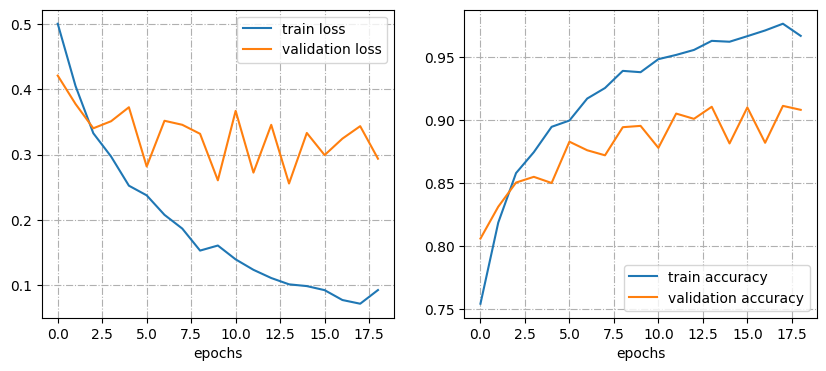

In [13]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'validation loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['acc'])
axs[1].plot(hist.history['val_acc'])
axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize = 10)

# <span style="color:#e74c3c;"> Validation, Test </span> Evaluations

In [14]:
# Validation and Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    val_eval_vit = model.evaluate(val_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
    print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
180/180 [==============================] - 5s 25ms/step - loss: 0.2936 - acc: 0.9081
Validation Loss: 0.294
Validation Accuracy: 90.813 %
----------------------------------------------------------------------------------------------------
90/90 [==============================] - 3s 26ms/step - loss: 0.2912 - acc: 0.9061
Test Loss: 0.291
Test Accuracy: 90.605 %


# <span style="color:#e74c3c;"> Test </span> Prediction

In [15]:
# predictions

with stg.scope():
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    pred = np.argmax(pred, axis = 1)
    
    
# Predictions and scores

mse = mean_squared_error(test_df['label'], pred)
f1 = f1_score(test_df['label'], pred, average = 'weighted')
acc = accuracy_score(test_df['label'], pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

2023-11-20 11:43:47.343972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


90/90 [==============================] - 15s 25ms/step
Mean Squared Error : 0.09395
Weighted F1 Score : 0.906
Accuracy Score : 90.605 %


# <span style="color:#e74c3c;"> Classification </span> Report

In [16]:
clf = classification_report(test_df['label'], pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

non-glaucoma       0.91      0.94      0.92      1754
    glaucoma       0.90      0.85      0.88      1120

    accuracy                           0.91      2874
   macro avg       0.90      0.90      0.90      2874
weighted avg       0.91      0.91      0.91      2874



# <span style="color:#e74c3c;"> Confusion </span> Matrix

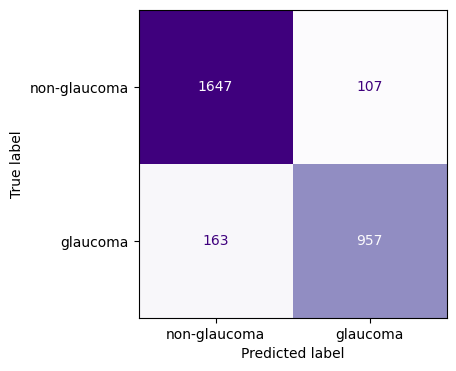

In [17]:
cm = confusion_matrix(test_df['label'], pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(4,4))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [18]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

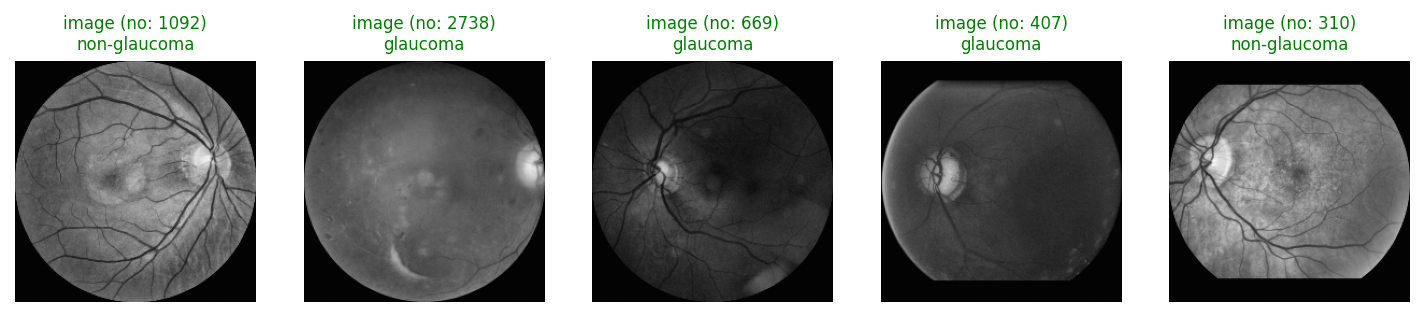

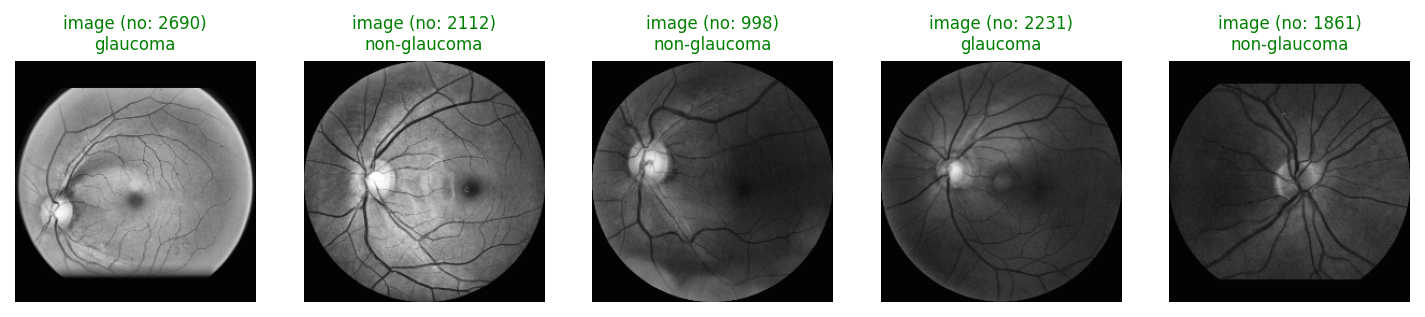

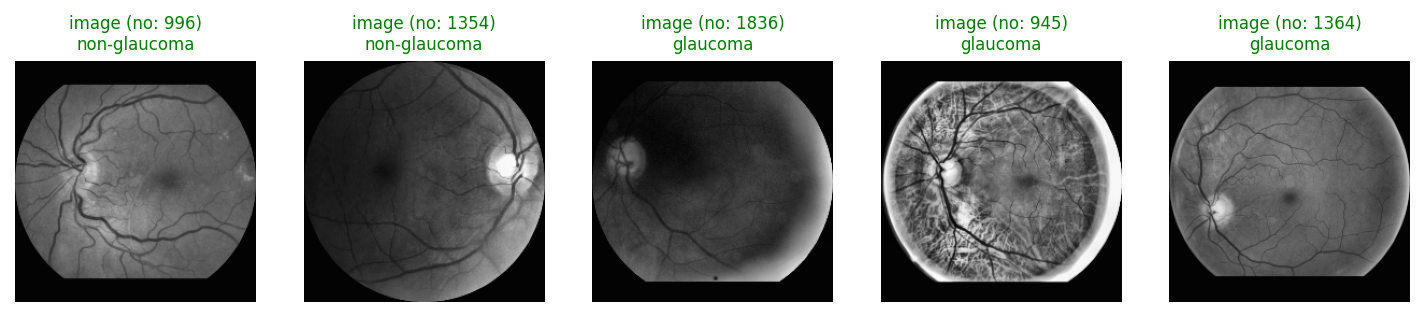

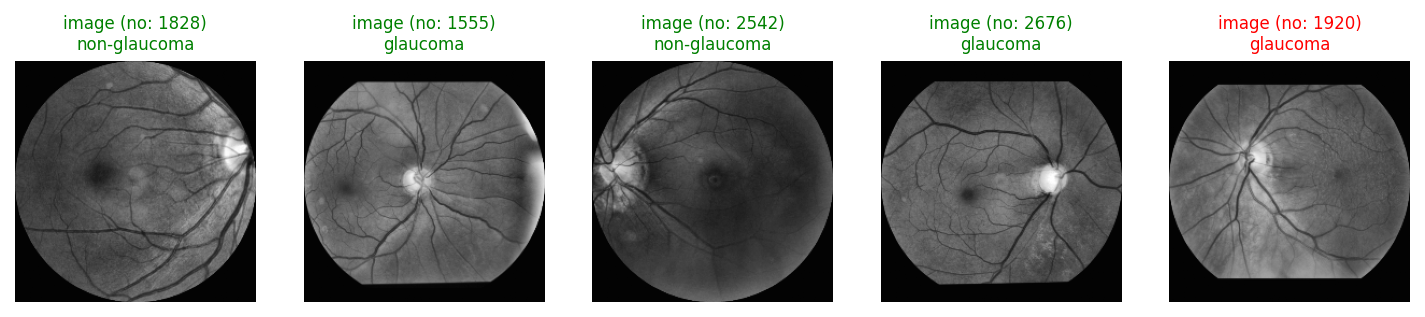

In [19]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 14)
random_test_sample_with_prediction(SEED = 53)
random_test_sample_with_prediction(SEED = 674)
random_test_sample_with_prediction(SEED = 9)